# Word2Vec: CBOW Model (Continuous Bag of Words)
-------------------------------------

In this example, we will download and preprocess the movie review data.

From this data set we will compute/fit the CBOW model of the Word2Vec Algorithm.

We start by loading the necessary libraries.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Load text helpers
import text_helpers

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Make a saving directory if it doesn't exist

In [2]:
data_folder_name = 'temp'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)

Start a computational graph session.

In [3]:
sess = tf.Session()

Declare model parameters.  Also note that we will save the model every 5000 iterations and print out the validation and loss at specified intervals.

In [4]:
batch_size = 200            # Model Batch Size
embedding_size = 50        # word embedding size
vocabulary_size = 2000      # Maximum vocabulary size
generations = 50000         # number of iterations for training.
model_learning_rate = 0.05   # Learning rate

num_sampled = int(batch_size/2) # Number of negative examples to sample.
window_size = 3                 # How many words to consider left and right.

# Add checkpoints to training
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 1000

Now we declare stop words, test words, and normalize our text.

In [5]:
# Declare stop words
stops = stopwords.words('english')

# We pick some test words. We are expecting synonyms to appear
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']
# Later we will have to transform these into indices

# Load the movie review data
print('Loading Data')
texts, target = text_helpers.load_movie_data()

# Normalize text
print('Normalizing Text Data')
texts = text_helpers.normalize_text(texts, stops)

# Texts must contain at least 3 words
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 2]
texts = [x for x in texts if len(x.split()) > 2]
print('Done.')

Loading Data
Normalizing Text Data
Done.


Now we build our dataset and word dictionaries.

In [6]:
# Build our data set and dictionaries
print('Creating Dictionary')
word_dictionary = text_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_helpers.text_to_numbers(texts, word_dictionary)

# Get validation word keys
valid_examples = [word_dictionary[x] for x in valid_words]    

Creating Dictionary


We create the CBOW model here.  We also create the placeholders necessary for the CBOW.

In [7]:
print('Creating Model')
# Define Embeddings:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# NCE loss parameters
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                               stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Create data/target placeholders
x_inputs = tf.placeholder(tf.int32, shape=[batch_size, 2*window_size])
y_target = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Lookup the word embedding
# Add together window embeddings:
embed = tf.zeros([batch_size, embedding_size])
for element in range(2*window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

Creating Model


Now we create the loss, optimization function, and the cosine similarity between word vectors.

In [8]:
# Get loss from prediction
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))

# Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate).minimize(loss)

# Cosine similarity between words
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Now we create a model saving operation and initialize the model variables.

In [9]:
# Create model saving operation
saver = tf.train.Saver({"embeddings": embeddings})

#Add variable initializer.
init = tf.global_variables_initializer()
sess.run(init)

We need to make sure that all sentences have at least N words, where N is $(2 * WindowSize + 1)$.  So in this case, where window size is 3, we need to use sentences that have at least 7 words.

In [10]:
# Filter out sentences that aren't long enough:
text_data = [x for x in text_data if len(x)>=(2*window_size+1)]

Now we start the CBOW training.

In [11]:
# Run the CBOW model.
print('Starting Training')
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = text_helpers.generate_batch_data(text_data, batch_size,
                                                                  window_size, method='cbow')
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # Run the train step
    sess.run(optimizer, feed_dict=feed_dict)

    # Return the loss
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    # Validation: Print some random words and top 5 related words
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},' .format(log_str, close_word)
            print(log_str)
            
    # Save dictionary + embeddings
    if (i+1) % save_embeddings_every == 0:
        # Save vocabulary dictionary
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # Save embeddings
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'cbow_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Starting Training
Loss at step 1000 : 7.859398365020752
Loss at step 2000 : 5.849699020385742
Loss at step 3000 : 5.742137908935547
Loss at step 4000 : 5.351024150848389
Loss at step 5000 : 5.0507025718688965
Nearest to love: standard, took, audience, thats, written,
Nearest to hate: sit, degree, odd, pieces, tough,
Nearest to happy: close, attitude, community, change, looking,
Nearest to sad: sophisticated, lead, length, example, good,
Nearest to man: humanity, revolution, movies, help, typical,
Nearest to woman: drama, animal, example, sum, provides,
Model saved in file: /home/jovyan/tensorflow/tensorflow-cookbook/07_Natural_Language_Processing/05_Working_With_CBOW_Embeddings/temp/cbow_movie_embeddings.ckpt
Loss at step 6000 : 4.8719162940979
Loss at step 7000 : 5.04575777053833
Loss at step 8000 : 4.9670491218566895
Loss at step 9000 : 4.961996555328369
Loss at step 10000 : 4.5171895027160645
Nearest to love: standard, took, death, written, audience,
Nearest to hate: sit, degree, od

Here is some matplotlib code to plot the training loss.

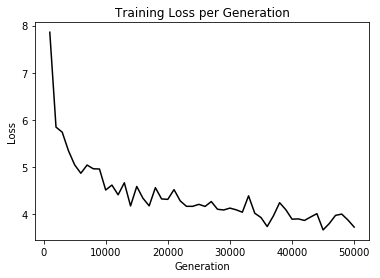

In [12]:
# Plot loss over time
plt.plot(loss_x_vec, loss_vec, 'k-')
plt.title('Training Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [ ]:
test complete; Gopal